In [1]:
# 주의! ray를 pytorch보다 먼저 import하면 오류가 발생할 수 있습니다
import io, json, os, math

import torch
import torch.nn as nn
import torch.nn.functional as F

import ray

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# 프로젝트 경로 설정
PROJECT_PATH = os.path.join('./posedata')
IMAGE_PATH = os.path.join(PROJECT_PATH, 'images')
MODEL_PATH = os.path.join(PROJECT_PATH, 'models')
PT_RECORD_PATH = os.path.join(PROJECT_PATH, 'ptrecords_mpii')
TRAIN_JSON = os.path.join(PROJECT_PATH, 'mpii_human_pose_v1_u12_2', 'train.json')
VALID_JSON = os.path.join(PROJECT_PATH, 'mpii_human_pose_v1_u12_2', 'validation.json')

print('슝=3')

c:\Users\user\anaconda3\envs\aiffel\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-12-03 15:36:10,341	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


슝=3


In [2]:
with open(TRAIN_JSON) as train_json:
    train_annos = json.load(train_json)
    json_formatted_str = json.dumps(train_annos[0], indent=2)
    print(json_formatted_str)

{
  "joints_vis": [
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1
  ],
  "joints": [
    [
      620.0,
      394.0
    ],
    [
      616.0,
      269.0
    ],
    [
      573.0,
      185.0
    ],
    [
      647.0,
      188.0
    ],
    [
      661.0,
      221.0
    ],
    [
      656.0,
      231.0
    ],
    [
      610.0,
      187.0
    ],
    [
      647.0,
      176.0
    ],
    [
      637.0201,
      189.8183
    ],
    [
      695.9799,
      108.1817
    ],
    [
      606.0,
      217.0
    ],
    [
      553.0,
      161.0
    ],
    [
      601.0,
      167.0
    ],
    [
      692.0,
      185.0
    ],
    [
      693.0,
      240.0
    ],
    [
      688.0,
      313.0
    ]
  ],
  "image": "015601864.jpg",
  "scale": 3.021046,
  "center": [
    594.0,
    257.0
  ]
}


0 - 오른쪽 발목 / 1 - 오른쪽 무릎 / 2 - 오른쪽 엉덩이 / 3 - 왼쪽 엉덩이 / 4 - 왼쪽 무릎 / 5 - 왼쪽 발목 / 6 - 골반 / 7 - 가슴(흉부) / 8 - 목 / 9 - 머리 위 / 10 - 오른쪽 손목 / 11 - 오른쪽 팔꿈치 / 12 - 오른쪽 어깨 / 13 - 왼쪽 어깨 / 14 - 왼쪽 팔꿈치 / 15 - 왼쪽 손목

In [3]:
#json annotation 파싱 함수
def parse_one_annotation(anno, image_dir):
    filename = anno['image']
    joints = anno['joints']
    joints_visibility = anno['joints_vis']
    annotation = {
        'filename': filename,
        'filepath': os.path.join(image_dir, filename),
        'joints_visibility': joints_visibility,
        'joints': joints,
        'center': anno['center'],
        'scale' : anno['scale']
    }
    return annotation

print('슝=3')

슝=3


In [4]:
with open(TRAIN_JSON) as train_json:
    train_annos = json.load(train_json)
    test = parse_one_annotation(train_annos[0], IMAGE_PATH)
    print(test)

{'filename': '015601864.jpg', 'filepath': './posedata\\images\\015601864.jpg', 'joints_visibility': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'joints': [[620.0, 394.0], [616.0, 269.0], [573.0, 185.0], [647.0, 188.0], [661.0, 221.0], [656.0, 231.0], [610.0, 187.0], [647.0, 176.0], [637.0201, 189.8183], [695.9799, 108.1817], [606.0, 217.0], [553.0, 161.0], [601.0, 167.0], [692.0, 185.0], [693.0, 240.0], [688.0, 313.0]], 'center': [594.0, 257.0], 'scale': 3.021046}


DataLoader 파일

In [5]:
# annotation를 pt 형식으로 변환하는 함수
def generate_ptexample(anno):
    filename = anno['filename']
    filepath = anno['filepath']

    # 이미지 파일 읽기
    with open(filepath, 'rb') as image_file:
        content = image_file.read()

    image = Image.open(filepath)
    # JPEG 형식 및 RGB 모드가 아니면 변환
    if image.format != 'JPEG' or image.mode != 'RGB':
        image_rgb = image.convert('RGB')
        with io.BytesIO() as output:
            image_rgb.save(output, format="JPEG", quality=95)
            content = output.getvalue()

    width, height = image.size
    depth = 3

    c_x = int(anno['center'][0])
    c_y = int(anno['center'][1])
    scale = anno['scale']

    x = [int(joint[0]) if joint[0] >= 0 else int(joint[0])
         for joint in anno['joints']]
    y = [int(joint[1]) if joint[1] >= 0 else int(joint[0])
         for joint in anno['joints']]

    v = [0 if joint_v == 0 else 2 for joint_v in anno['joints_visibility']]

    feature = {
        'image/height': height,
        'image/width': width,
        'image/depth': depth,
        'image/object/parts/x': x,
        'image/object/parts/y': y,
        'image/object/center/x': c_x,
        'image/object/center/y': c_y,
        'image/object/scale': scale,
        'image/object/parts/v': v,
        'image/encoded': content,
        'image/filename': filename.encode()  # bytes로 저장
    }

    return feature

print('슝=3')

슝=3


In [6]:
# pt 생성개수를 결정하는 함수
def chunkify(l, n):
    size = len(l) // n
    start = 0
    results = []
    for i in range(n):
        results.append(l[start:start + size])
        start += size
    return results

# 테스트
test_chunks = chunkify([0] * 1000, 64)
print(test_chunks)
print(len(test_chunks))
print(len(test_chunks[0]))

[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0,

In [7]:
# 하나의 chunk에 대해 pt를 생성하는 함수
import pickle

@ray.remote
def build_single_ptrecord(chunk, path):
    print('start to build ptrecord for ' + path)

    with open(path, 'wb') as writer:
        for anno in chunk:
            ptexample = generate_ptexample(anno)
            pickle.dump(ptexample, writer)

    print('finished building ptrecord for ' + path)

print('슝=3')

슝=3


In [8]:
# 전체 데이터를 pt로 생성
def build_pt_records(annotations, total_shards, split):
    chunks = chunkify(annotations, total_shards)
    futures = [
        build_single_ptrecord.remote(
            chunk, '{}/{}_{}_of_{}.ptrecords'.format(
                PT_RECORD_PATH,
                split,
                str(i + 1).zfill(4),
                str(total_shards).zfill(4),
            )
        ) for i, chunk in enumerate(chunks)
    ]
    ray.get(futures)

print('슝=3')

슝=3


In [9]:
from torch.utils.data import Dataset

class MPIIDataset(Dataset):
    def __init__(self, annotation_file, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform

        # JSON 파일을 읽어 annotations 리스트 생성
        with open(annotation_file, 'r') as f:
            annotations = json.load(f)

        # 각 annotation을 파싱하여 리스트에 저장
        self.annotations = [parse_one_annotation(anno, image_dir) for anno in annotations]

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        anno = self.annotations[idx]
        # 이미지 파일 경로로부터 이미지를 로드 (RGB 모드로 변환)
        image = Image.open(anno['filepath']).convert('RGB')

        # transform이 있으면 적용
        if self.transform:
            image, heatmaps = self.transform({'image': image, 'annotation': anno})
            return image, heatmaps
        else:
            # transform이 없으면 원본 이미지와 annotation dict 반환
            return image, anno

In [10]:
# 경로가 자동생성되지 않는다면 아래 코드를 실행해주세요.
# os.makedirs(os.path.join(PT_RECORD_PATH, 'train'), exist_ok=True)
# os.makedirs(os.path.join(PT_RECORD_PATH, 'val'), exist_ok=True)

In [11]:
# 시간 좀 걸릴수도 있음
#%%time
num_train_shards = 64
num_val_shards = 8

ray.init()

print('Start to parse annotations.')
if not os.path.exists(PT_RECORD_PATH):
    os.makedirs(PT_RECORD_PATH)

with open(TRAIN_JSON) as train_json:
    train_annos = json.load(train_json)
    train_annotations = [
        parse_one_annotation(anno, IMAGE_PATH)
        for anno in train_annos
    ]
    print('First train annotation: ', train_annotations[0])

with open(VALID_JSON) as val_json:
    val_annos = json.load(val_json)
    val_annotations = [
        parse_one_annotation(anno, IMAGE_PATH)
        for anno in val_annos
    ]
    print('First val annotation: ', val_annotations[0])

print('Start to build PT Records.')
build_pt_records(train_annotations, num_train_shards, 'train')
build_pt_records(val_annotations, num_val_shards, 'val')

print('Successfully wrote {} annotations to PT Records.'.format(
    len(train_annotations) + len(val_annotations)))

2025-12-03 15:36:12,882	INFO worker.py:2023 -- Started a local Ray instance.
c:\Users\user\anaconda3\envs\aiffel\lib\site-packages\ray\_private\worker.py:2062: FutureWarning: Tip: In future versions of Ray, Ray will no longer override accelerator visible devices env var if num_gpus=0 or num_gpus=None (default). To enable this behavior and turn off this error message, set RAY_ACCEL_ENV_VAR_OVERRIDE_ON_ZERO=0
  warnings.warn(


Start to parse annotations.
First train annotation:  {'filename': '015601864.jpg', 'filepath': './posedata\\images\\015601864.jpg', 'joints_visibility': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'joints': [[620.0, 394.0], [616.0, 269.0], [573.0, 185.0], [647.0, 188.0], [661.0, 221.0], [656.0, 231.0], [610.0, 187.0], [647.0, 176.0], [637.0201, 189.8183], [695.9799, 108.1817], [606.0, 217.0], [553.0, 161.0], [601.0, 167.0], [692.0, 185.0], [693.0, 240.0], [688.0, 313.0]], 'center': [594.0, 257.0], 'scale': 3.021046}
First val annotation:  {'filename': '005808361.jpg', 'filepath': './posedata\\images\\005808361.jpg', 'joints_visibility': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'joints': [[804.0, 711.0], [816.0, 510.0], [908.0, 438.0], [1040.0, 454.0], [906.0, 528.0], [883.0, 707.0], [974.0, 446.0], [985.0, 253.0], [982.7591, 235.9694], [962.2409, 80.0306], [869.0, 214.0], [798.0, 340.0], [902.0, 253.0], [1067.0, 253.0], [1167.0, 353.0], [1142.0, 478.0]], 'center': [966.0

data label로 만들기

In [12]:
from tfrecord.torch.dataset import TFRecordDataset

feature_description = {
    'image/height': 'int',
    'image/width': 'int',
    'image/depth': 'int',
    'image/object/parts/x': 'int',
    'image/object/parts/y': 'int',
    'image/object/parts/v': 'int',
    'image/object/center/x': 'int',
    'image/object/center/y': 'int',
    'image/object/scale': 'float',
    'image/encoded': 'byte',
    'image/filename': 'byte',
}

print('슝=3')

슝=3


In [13]:
import torch

def crop_roi(image, features, margin=0.2):
    img_height, img_width, img_depth = image.shape

    keypoint_x = torch.tensor(features['image/object/parts/x'], dtype=torch.int32)
    keypoint_y = torch.tensor(features['image/object/parts/y'], dtype=torch.int32)
    center_x = features['image/object/center/x']
    center_y = features['image/object/center/y']
    body_height = features['image/object/scale'] * 200.0

    # 유효한 keypoint (값이 0보다 큰 값)만 선택합니다.
    masked_keypoint_x = keypoint_x[keypoint_x > 0]
    masked_keypoint_y = keypoint_y[keypoint_y > 0]

    # 최소, 최대 값 계산 (유효한 keypoint가 하나 이상 있다고 가정)
    keypoint_xmin = masked_keypoint_x.min()
    keypoint_xmax = masked_keypoint_x.max()
    keypoint_ymin = masked_keypoint_y.min()
    keypoint_ymax = masked_keypoint_y.max()

    # margin을 적용하여 경계를 확장 (body_height * margin 값을 정수로 캐스팅)
    extra = int(body_height * margin)
    xmin = int(keypoint_xmin.item()) - extra
    xmax = int(keypoint_xmax.item()) + extra
    ymin = int(keypoint_ymin.item()) - extra
    ymax = int(keypoint_ymax.item()) + extra

    # 이미지 경계를 벗어나지 않도록 조정
    effective_xmin = xmin if xmin > 0 else 0
    effective_ymin = ymin if ymin > 0 else 0
    effective_xmax = xmax if xmax < img_width else img_width
    effective_ymax = ymax if ymax < img_height else img_height

    # 이미지 크기 재조정
    cropped_image = image[effective_ymin:effective_ymax, effective_xmin:effective_xmax, :]
    new_height, new_width, _ = cropped_image.shape

    # keypoint 좌표를 정규화 (0~1 범위)
    effective_keypoint_x = (keypoint_x.float() - effective_xmin) / new_width
    effective_keypoint_y = (keypoint_y.float() - effective_ymin) / new_height

    return cropped_image, effective_keypoint_x, effective_keypoint_y

print('슝=3')

(build_single_ptrecord pid=25644) finished building ptrecord for ./posedata\ptrecords_mpii/val_0006_of_0008.ptrecords
슝=3


In [14]:
import torch

def generate_2d_gaussian(height, width, y0, x0, visibility=2, sigma=1, scale=12):
    # (height, width) 크기의 0으로 채워진 heatmap 생성
    heatmap = torch.zeros((height, width), dtype=torch.float32)

    xmin = x0 - 3 * sigma
    ymin = y0 - 3 * sigma
    xmax = x0 + 3 * sigma
    ymax = y0 + 3 * sigma

    # 범위가 이미지 내에 없거나, visibility가 0이면 heatmap 그대로 반환
    if xmin >= width or ymin >= height or xmax < 0 or ymax < 0 or visibility == 0:
        return heatmap

    size = int(6 * sigma + 1)
    grid_range = torch.arange(0, size, dtype=torch.float32)
    x_grid, y_grid = torch.meshgrid(grid_range, grid_range, indexing='xy')
    center_x = size // 2
    center_y = size // 2

    # 가우시안 patch 계산
    gaussian_patch = torch.exp(-(((x_grid - center_x)**2 + (y_grid - center_y)**2) / (sigma**2 * 2))) * scale

    # 이미지와 patch 간의 겹치는 영역 계산
    patch_xmin = max(0, -xmin)
    patch_ymin = max(0, -ymin)
    patch_xmax = min(xmax, width) - xmin
    patch_ymax = min(ymax, height) - ymin

    heatmap_xmin = max(0, xmin)
    heatmap_ymin = max(0, ymin)
    heatmap_xmax = min(xmax, width)
    heatmap_ymax = min(ymax, height)

    # 계산된 영역에 gaussian_patch 값을 할당
    heatmap[heatmap_ymin:heatmap_ymax, heatmap_xmin:heatmap_xmax] = \
        gaussian_patch[int(patch_ymin):int(patch_ymax), int(patch_xmin):int(patch_xmax)]

    return heatmap

def make_heatmaps(features, keypoint_x, keypoint_y, heatmap_shape):
    v = torch.tensor(features['image/object/parts/v'], dtype=torch.float32)
    x = torch.round(torch.tensor(keypoint_x, dtype=torch.float32) * heatmap_shape[0]).to(torch.int32)
    y = torch.round(torch.tensor(keypoint_y, dtype=torch.float32) * heatmap_shape[1]).to(torch.int32)

    num_heatmap = heatmap_shape[2]
    heatmaps_list = []
    for i in range(num_heatmap):
        # generate_2d_gaussian 함수 호출 시, height=heatmap_shape[1], width=heatmap_shape[0]
        gaussian = generate_2d_gaussian(
            heatmap_shape[1],
            heatmap_shape[0],
            int(y[i].item()),
            int(x[i].item()),
            visibility=int(v[i].item())
        )
        heatmaps_list.append(gaussian)

    # (num_heatmap, height, width) 텐서를 생성한 후, (height, width, num_heatmap)로 전치
    heatmaps = torch.stack(heatmaps_list, dim=0)
    heatmaps = heatmaps.permute(1, 2, 0)

    return heatmaps

print('슝=3')

슝=3


In [15]:
import torch
from PIL import Image
import io
import numpy as np

class Preprocessor(object):
    def __init__(self,
                 image_shape=(256, 256, 3),
                 heatmap_shape=(64, 64, 16),
                 is_train=False):
        self.is_train = is_train
        self.image_shape = image_shape      # (height, width, channels)
        self.heatmap_shape = heatmap_shape  # (height, width, num_heatmap)

    def __call__(self, example):
        features = self.parse_tfexample(example)
        # image 데이터를 다시 bytes로 디코딩 후 재로딩 (JPEG 형식)
        image = Image.open(io.BytesIO(features['image/encoded']))

        if self.is_train:
            # 0.1 ~ 0.3 사이의 random margin 생성
            random_margin = torch.empty(1).uniform_(0.1, 0.3).item()
            image, keypoint_x, keypoint_y = self.crop_roi(image, features, margin=random_margin)
            image = image.resize((self.image_shape[1], self.image_shape[0]))
        else:
            image, keypoint_x, keypoint_y = self.crop_roi(image, features)
            image = image.resize((self.image_shape[1], self.image_shape[0]))

        # 이미지 정규화: uint8 → [0,255] → [-1, 1]
        image_np = np.array(image).astype(np.float32)
        image_np = image_np / 127.5 - 1.0
        # 채널 우선순서로 변환: (H, W, C) -> (C, H, W)
        image_tensor = torch.from_numpy(image_np).permute(2, 0, 1)

        heatmaps = self.make_heatmaps(features, keypoint_x, keypoint_y, self.heatmap_shape)

        return image_tensor, heatmaps

    def parse_tfexample(self, example):
        """
        MPIIDataset에서 전달한 예제를 받아, Preprocessor가 처리할 수 있도록 features dict를 구성합니다.
        예제 형식: {'image': PIL.Image, 'annotation': anno}
        """
        annotation = example['annotation']
        # joints: list of [x, y]
        joints = annotation['joints']
        keypoint_x = [joint[0] for joint in joints]
        keypoint_y = [joint[1] for joint in joints]

        # joints_vis가 없으면 모든 관절이 가시적이라고 가정 (1)
        joints_vis = annotation.get('joints_vis', [1] * len(joints))

        features = {
            'image/encoded': self.image_to_bytes(example['image']),
            'image/object/parts/x': keypoint_x,
            'image/object/parts/y': keypoint_y,
            'image/object/parts/v': joints_vis,
            'image/object/center/x': annotation['center'][0],
            'image/object/center/y': annotation['center'][1],
            'image/object/scale': annotation['scale'],
        }
        return features

    def image_to_bytes(self, image):
        """
        PIL.Image 객체를 JPEG 인코딩된 bytes로 변환합니다.
        """
        buffer = io.BytesIO()
        image.save(buffer, format="JPEG")
        return buffer.getvalue()

    def crop_roi(self, image, features, margin=0.2):
        # image: PIL.Image, features: dict
        img_width, img_height = image.size  # PIL: (width, height)

        keypoint_x = torch.tensor(features['image/object/parts/x'], dtype=torch.int32)
        keypoint_y = torch.tensor(features['image/object/parts/y'], dtype=torch.int32)
        body_height = features['image/object/scale'] * 200.0

        # 유효한 keypoint (값 > 0)만 선택
        masked_keypoint_x = keypoint_x[keypoint_x > 0]
        masked_keypoint_y = keypoint_y[keypoint_y > 0]

        keypoint_xmin = int(masked_keypoint_x.min().item())
        keypoint_xmax = int(masked_keypoint_x.max().item())
        keypoint_ymin = int(masked_keypoint_y.min().item())
        keypoint_ymax = int(masked_keypoint_y.max().item())

        extra = int(body_height * margin)
        xmin = keypoint_xmin - extra
        xmax = keypoint_xmax + extra
        ymin = keypoint_ymin - extra
        ymax = keypoint_ymax + extra

        effective_xmin = max(xmin, 0)
        effective_ymin = max(ymin, 0)
        effective_xmax = min(xmax, img_width)
        effective_ymax = min(ymax, img_height)

        cropped_image = image.crop((effective_xmin, effective_ymin, effective_xmax, effective_ymax))

        new_width = effective_xmax - effective_xmin
        new_height = effective_ymax - effective_ymin

        effective_keypoint_x = (keypoint_x.float() - effective_xmin) / new_width
        effective_keypoint_y = (keypoint_y.float() - effective_ymin) / new_height

        return cropped_image, effective_keypoint_x, effective_keypoint_y

    def generate_2d_guassian(self, height, width, y0, x0, visibility=2, sigma=1, scale=12):
        heatmap = torch.zeros((height, width), dtype=torch.float32)

        xmin = x0 - 3 * sigma
        ymin = y0 - 3 * sigma
        xmax = x0 + 3 * sigma
        ymax = y0 + 3 * sigma

        if xmin >= width or ymin >= height or xmax < 0 or ymax < 0 or visibility == 0:
            return heatmap

        size = int(6 * sigma + 1)
        grid_range = torch.arange(0, size, dtype=torch.float32)
        x_grid, y_grid = torch.meshgrid(grid_range, grid_range, indexing='xy')
        center_x = size // 2
        center_y = size // 2

        gaussian_patch = torch.exp(-(((x_grid - center_x)**2 + (y_grid - center_y)**2) / (2 * sigma**2))) * scale

        patch_xmin = max(0, -xmin)
        patch_ymin = max(0, -ymin)
        patch_xmax = min(xmax, width) - xmin
        patch_ymax = min(ymax, height) - ymin

        heatmap_xmin = max(0, xmin)
        heatmap_ymin = max(0, ymin)
        heatmap_xmax = min(xmax, width)
        heatmap_ymax = min(ymax, height)

        heatmap[heatmap_ymin:heatmap_ymax, heatmap_xmin:heatmap_xmax] = \
            gaussian_patch[int(patch_ymin):int(patch_ymax), int(patch_xmin):int(patch_xmax)]

        return heatmap

    def make_heatmaps(self, features, keypoint_x, keypoint_y, heatmap_shape):
        # heatmap_shape: (height, width, num_heatmap)
        v = torch.tensor(features['image/object/parts/v'], dtype=torch.float32)
        x = torch.round(keypoint_x * heatmap_shape[1]).to(torch.int32)  # width: heatmap_shape[1]
        y = torch.round(keypoint_y * heatmap_shape[0]).to(torch.int32)  # height: heatmap_shape[0]

        num_heatmap = heatmap_shape[2]
        heatmaps_list = []

        for i in range(num_heatmap):
            gaussian = self.generate_2d_guassian(
                height=heatmap_shape[0],
                width=heatmap_shape[1],
                y0=int(y[i].item()),
                x0=int(x[i].item()),
                visibility=int(v[i].item())
            )
            heatmaps_list.append(gaussian)

        # 스택 후, (num_heatmap, height, width) 형태로 반환
        heatmaps = torch.stack(heatmaps_list, dim=0)
        return heatmaps

print('슝=3')

슝=3


여기까지 데이터 전처리  
아래는 Hourglass 모델 만들기

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BottleneckBlock(nn.Module):
    def __init__(self, in_channels, filters, stride=1, downsample=False):
        super(BottleneckBlock, self).__init__()
        self.downsample = downsample
        # 만약 downsample이라면 identity branch에 1x1 conv 적용하여 채널 수와 spatial size 조정
        if self.downsample:
            self.downsample_conv = nn.Conv2d(in_channels, filters, kernel_size=1, stride=stride, bias=False)

        # main branch
        self.bn1 = nn.BatchNorm2d(in_channels, momentum=0.9)
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_channels, filters // 2, kernel_size=1, stride=1, padding=0, bias=False)

        self.bn2 = nn.BatchNorm2d(filters // 2, momentum=0.9)
        # kernel_size=3, padding=1로 'same' padding 효과
        self.conv2 = nn.Conv2d(filters // 2, filters // 2, kernel_size=3, stride=stride, padding=1, bias=False)

        self.bn3 = nn.BatchNorm2d(filters // 2, momentum=0.9)
        self.conv3 = nn.Conv2d(filters // 2, filters, kernel_size=1, stride=1, padding=0, bias=False)

    def forward(self, x):
        identity = x
        if self.downsample:
            identity = self.downsample_conv(x)

        out = self.bn1(x)
        out = self.relu(out)
        out = self.conv1(out)

        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv2(out)

        out = self.bn3(out)
        out = self.relu(out)
        out = self.conv3(out)

        out += identity
        return out

print('슝=3')

슝=3


In [17]:
import torch
import torch.nn as nn

class HourglassModule(nn.Module):
    def __init__(self, order, filters, num_residual):
        super(HourglassModule, self).__init__()
        self.order = order

        # Up branch: BottleneckBlock 1회 + num_residual회 반복
        self.up1_0 = BottleneckBlock(in_channels=filters, filters=filters, stride=1, downsample=False)
        self.up1_blocks = nn.Sequential(*[
            BottleneckBlock(in_channels=filters, filters=filters, stride=1, downsample=False)
            for _ in range(num_residual)
        ])

        # Low branch: MaxPool + num_residual BottleneckBlock
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.low1_blocks = nn.Sequential(*[
            BottleneckBlock(in_channels=filters, filters=filters, stride=1, downsample=False)
            for _ in range(num_residual)
        ])

        # Recursive hourglass or additional BottleneckBlocks
        if order > 1:
            self.low2 = HourglassModule(order - 1, filters, num_residual)
        else:
            self.low2_blocks = nn.Sequential(*[
                BottleneckBlock(in_channels=filters, filters=filters, stride=1, downsample=False)
                for _ in range(num_residual)
            ])

        # 후처리 BottleneckBlock 반복
        self.low3_blocks = nn.Sequential(*[
            BottleneckBlock(in_channels=filters, filters=filters, stride=1, downsample=False)
            for _ in range(num_residual)
        ])

        # UpSampling (최근접 보간법)
        self.upsample = nn.Upsample(scale_factor=2, mode='nearest')

    def forward(self, x):
        # up branch
        up1 = self.up1_0(x)
        up1 = self.up1_blocks(up1)

        # low branch
        low1 = self.pool(x)
        low1 = self.low1_blocks(low1)
        if self.order > 1:
            low2 = self.low2(low1)
        else:
            low2 = self.low2_blocks(low1)
        low3 = self.low3_blocks(low2)
        up2 = self.upsample(low3)

        return up2 + up1

print('슝=3')

슝=3


In [18]:
import torch
import torch.nn as nn

class LinearLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(LinearLayer, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn = nn.BatchNorm2d(out_channels, momentum=0.9)
        self.relu = nn.ReLU(inplace=True)

        # He (Kaiming) 초기화 적용
        nn.init.kaiming_normal_(self.conv.weight, mode='fan_out', nonlinearity='relu')

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x

print('슝=3')

슝=3


In [19]:
import torch
import torch.nn as nn

class StackedHourglassNetwork(nn.Module):
    def __init__(self, input_shape=(256, 256, 3), num_stack=4, num_residual=1, num_heatmap=16):
        super(StackedHourglassNetwork, self).__init__()
        self.num_stack = num_stack

        in_channels = input_shape[2]  # 3
        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64, momentum=0.9)
        self.relu = nn.ReLU(inplace=True)

        # Bottleneck blocks 초기화
        # BottleneckBlock의 첫번째 호출: 64 → 128, downsample=True
        self.bottleneck1 = BottleneckBlock(in_channels=64, filters=128, stride=1, downsample=True)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # 두 번째: 128 → 128, downsample=False
        self.bottleneck2 = BottleneckBlock(in_channels=128, filters=128, stride=1, downsample=False)
        # 세 번째: 128 → 256, downsample=True
        self.bottleneck3 = BottleneckBlock(in_channels=128, filters=256, stride=1, downsample=True)

        # 스택 구성 요소들
        self.hourglass_modules = nn.ModuleList()
        self.residual_modules = nn.ModuleList()  # hourglass 후 residual block들 (num_residual회)
        self.linear_layers = nn.ModuleList()
        self.heatmap_convs = nn.ModuleList()
        # 마지막 스택을 제외한 중간 피쳐 결합용 1x1 conv
        self.intermediate_convs = nn.ModuleList()
        self.intermediate_outs = nn.ModuleList()

        for i in range(num_stack):
            # order=4인 hourglass 모듈 (앞에서 정의한 HourglassModule 사용)
            self.hourglass_modules.append(HourglassModule(order=4, filters=256, num_residual=num_residual))
            # hourglass 후 residual block들
            self.residual_modules.append(nn.Sequential(*[
                BottleneckBlock(in_channels=256, filters=256, stride=1, downsample=False)
                for _ in range(num_residual)
            ]))
            # Linear layer: 1x1 conv + BN + ReLU (앞에서 정의한 LinearLayer 사용)
            self.linear_layers.append(LinearLayer(in_channels=256, out_channels=256))
            # 최종 heatmap을 생성하는 1x1 conv
            self.heatmap_convs.append(nn.Conv2d(256, num_heatmap, kernel_size=1, stride=1, padding=0))

            if i < num_stack - 1:
                self.intermediate_convs.append(nn.Conv2d(256, 256, kernel_size=1, stride=1, padding=0))
                self.intermediate_outs.append(nn.Conv2d(num_heatmap, 256, kernel_size=1, stride=1, padding=0))

    def forward(self, x):
        # x: (B, 3, H, W)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.bottleneck1(x)
        x = self.pool(x)
        x = self.bottleneck2(x)
        x = self.bottleneck3(x)

        outputs = []
        for i in range(self.num_stack):
            hg = self.hourglass_modules[i](x)
            res = self.residual_modules[i](hg)
            lin = self.linear_layers[i](res)
            heatmap = self.heatmap_convs[i](lin)
            outputs.append(heatmap)

            if i < self.num_stack - 1:
                inter1 = self.intermediate_convs[i](lin)
                inter2 = self.intermediate_outs[i](heatmap)
                x = inter1 + inter2  # 다음 스택의 입력으로 사용

        return outputs

print('슝=3')

슝=3


학습 엔진 만들기

In [20]:
import os
import math
import torch
import torch.nn as nn
import torch.optim as optim

class Trainer(object):
    def __init__(self,
                 model,
                 epochs,
                 global_batch_size,
                 initial_learning_rate):
        """
        - model: 학습시킬 PyTorch 모델(nn.Module)
        - epochs: 전체 학습 epoch 수
        - global_batch_size: 전체 배치 크기 (loss 계산 시 사용)
        - initial_learning_rate: 초기 학습률
        """
        self.model = model
        self.epochs = epochs
        self.global_batch_size = global_batch_size

        # MSE loss를 reduction='none'으로 사용 (가중치 적용을 위해)
        self.loss_object = nn.MSELoss(reduction='none')

        # Adam optimizer 초기화
        self.optimizer = optim.Adam(self.model.parameters(), lr=initial_learning_rate)

        # 학습률 스케줄링 관련 변수들
        self.current_learning_rate = initial_learning_rate
        self.last_val_loss = math.inf
        self.lowest_val_loss = math.inf
        self.patience_count = 0
        self.max_patience = 10

        # 최적 모델 체크포인트 저장
        self.best_model = None

        # 단일 GPU/멀티 GPU(DataParallel) 설정
        if torch.cuda.device_count() > 1:
            print(f"멀티 GPU 사용 (GPU 개수: {torch.cuda.device_count()})")
            self.model = nn.DataParallel(self.model)
        else:
            print("단일 GPU 혹은 CPU 사용")

    def lr_decay(self):
        """
        patience_count가 max_patience를 넘으면 학습률을 1/10으로 감소,
        그렇지 않고 val_loss가 그대로면 patience_count += 1,
        새 최저 val_loss를 달성하면 patience_count를 0으로.
        """
        if self.patience_count >= self.max_patience:
            self.current_learning_rate /= 10.0
            self.patience_count = 0
        elif self.last_val_loss == self.lowest_val_loss:
            self.patience_count = 0

        self.patience_count += 1

        # optimizer의 learning rate 갱신
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = self.current_learning_rate

    def lr_decay_step(self, epoch):
        """
        25, 50, 75 epoch에서 학습률을 1/10으로 감소시키는 스케줄링.
        """
        if epoch in [25, 50, 75]:
            self.current_learning_rate /= 10.0

        for param_group in self.optimizer.param_groups:
            param_group['lr'] = self.current_learning_rate

    def compute_loss(self, labels, outputs):
        """
        여러 스택의 heatmap 출력(outputs)에 대해 MSE를 구하되,
        labels > 0인 위치에는 81의 추가 가중치를 적용.
        """
        loss = 0
        for output in outputs:
            # labels > 0 이면 81 + 1 = 82, 아니면 1
            weights = (labels > 0).float() * 81 + 1
            squared_error = (labels - output) ** 2
            weighted_error = squared_error * weights
            # 전체 배치에 대한 평균 후, global_batch_size로 나눔
            loss += weighted_error.mean() / self.global_batch_size
        return loss

    def train_step(self, images, labels, device):
        self.model.train()
        images = images.to(device)
        labels = labels.to(device)

        self.optimizer.zero_grad()
        outputs = self.model(images)
        loss = self.compute_loss(labels, outputs)
        loss.backward()
        self.optimizer.step()

        return loss.item()

    def val_step(self, images, labels, device):
        self.model.eval()
        with torch.no_grad():
            images = images.to(device)
            labels = labels.to(device)
            outputs = self.model(images)
            loss = self.compute_loss(labels, outputs)
        return loss.item()

    def run(self, train_loader, val_loader, device):
        """
        - train_loader, val_loader: PyTorch DataLoader
        - device: torch.device('cuda' or 'cpu')
        """
        for epoch in range(1, self.epochs + 1):
            # 학습률 감소 로직
            self.lr_decay()
            print(f"Start epoch {epoch} with learning rate {self.current_learning_rate:.6f}")

            # Training
            total_train_loss = 0.0
            num_train_batches = 0
            for images, labels in train_loader:
                batch_loss = self.train_step(images, labels, device)
                total_train_loss += batch_loss
                num_train_batches += 1
                print(f"[Train] batch {num_train_batches} loss {batch_loss:.4f} "
                      f"avg_loss {total_train_loss/num_train_batches:.4f}")
            train_loss = total_train_loss / num_train_batches
            print(f"Epoch {epoch} train loss {train_loss:.4f}")

            # Validation
            total_val_loss = 0.0
            num_val_batches = 0
            for images, labels in val_loader:
                batch_loss = self.val_step(images, labels, device)
                num_val_batches += 1
                print(f"[Val] batch {num_val_batches} loss {batch_loss:.4f}")
                # NaN이 아닌 경우만 합산
                if not math.isnan(batch_loss):
                    total_val_loss += batch_loss
                else:
                    num_val_batches -= 1

            if num_val_batches > 0:
                val_loss = total_val_loss / num_val_batches
            else:
                val_loss = float('nan')

            print(f"Epoch {epoch} val loss {val_loss:.4f}")

            # 새로운 최저 val_loss 달성 시 모델 저장
            if val_loss < self.lowest_val_loss:
                self.save_model(epoch, val_loss)
                self.lowest_val_loss = val_loss
            self.last_val_loss = val_loss

        return self.best_model

    def save_model(self, epoch, loss):
        model_name = os.path.join(MODEL_PATH, f'model-epoch-{epoch}-loss-{loss:.4f}.pt')
        torch.save(self.model.state_dict(), model_name)
        self.best_model = model_name
        print(f"Model {model_name} saved.")

print('슝=3')

슝=3


In [21]:
from torch.utils.data import DataLoader

IMAGE_SHAPE = (256, 256, 3)
HEATMAP_SIZE = (64, 64)

def create_dataloader(annotation_file, image_dir, batch_size, num_heatmap, is_train=True):
    """
    annotation_file: JSON 파일 경로 (예: train.json)
    image_dir: 이미지 파일들이 저장된 디렉토리 경로
    batch_size: 배치 크기
    num_heatmap: 생성할 heatmap 개수
    is_train: True이면 shuffle 적용
    """

    preprocess = Preprocessor(
        image_shape=IMAGE_SHAPE,
        heatmap_shape=(HEATMAP_SIZE[0], HEATMAP_SIZE[1], num_heatmap),
        is_train=is_train
    )

    dataset = MPIIDataset(annotation_file=annotation_file, image_dir=image_dir, transform=preprocess)

    # DataLoader 생성
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=is_train,
        num_workers=4,
        pin_memory=True,
        drop_last=False,
        prefetch_factor= 2
    )

    return dataloader

In [22]:
def train(epochs, learning_rate, num_heatmap, batch_size, train_annotation_file, val_annotation_file, image_dir):
    """
    - epochs: 전체 학습 epoch 수
    - learning_rate: 초기 학습률
    - num_heatmap: 생성할 heatmap 개수
    - batch_size: 배치 크기
    - train_annotation_file: train.json 파일 경로
    - val_annotation_file: validation.json 파일 경로
    - image_dir: 이미지 파일들이 저장된 디렉토리 경로
    """
    global_batch_size = batch_size

    train_loader = create_dataloader(train_annotation_file, image_dir, batch_size, num_heatmap, is_train=True)
    val_loader = create_dataloader(val_annotation_file, image_dir, batch_size, num_heatmap, is_train=False)

    if not os.path.exists(MODEL_PATH):
        os.makedirs(MODEL_PATH)

    model = StackedHourglassNetwork(IMAGE_SHAPE, num_stack=4, num_residual=1, num_heatmap=num_heatmap)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    trainer = Trainer(
        model,
        epochs,
        global_batch_size,
        initial_learning_rate=learning_rate
    )

    print("Start training...")
    return trainer.run(train_loader, val_loader, device)

print('슝=3')

슝=3


학습 코드

In [ ]:
#%%time
# 아래 코드를 실행하면 직접 학습을 해볼 수 있습니다.
#import os

#TRAIN_JSON = os.path.join(PROJECT_PATH, 'mpii_human_pose_v1_u12_2', 'train.json')
#VAL_JSON = os.path.join(PROJECT_PATH, 'mpii_human_pose_v1_u12_2', 'validation.json')
#IMAGE_DIR = os.path.join(PROJECT_PATH, 'images')

#epochs = 2
#batch_size = 2
#num_heatmap = 16
#learning_rate = 0.0007

#if __name__ == '__main__':
#    best_model_file = train(epochs, learning_rate, num_heatmap, batch_size, TRAIN_JSON, VAL_JSON, IMAGE_DIR)

CPU times: total: 0 ns
Wall time: 0 ns


예측 엔진 만들기

In [24]:
import gdown

file_id = "1-F6ztKRSL7Lp0kVT7nPuSIfEpBWz1abZ"
output_path = "model-epoch-2-loss-1.2050.pt"
gdown.download(f"https://drive.google.com/uc?id={file_id}", output_path, quiet=False)
!mv model-epoch-2-loss-1.2050.pt ~/work/mpii/models

epochs = 2
batch_size = 16
num_heatmap = 16
learning_rate = 0.0007

Downloading...
From (original): https://drive.google.com/uc?id=1-F6ztKRSL7Lp0kVT7nPuSIfEpBWz1abZ
From (redirected): https://drive.google.com/uc?id=1-F6ztKRSL7Lp0kVT7nPuSIfEpBWz1abZ&confirm=t&uuid=060c2e20-2180-4922-ab33-efd846202764
To: c:\Users\user\Desktop\model-epoch-2-loss-1.2050.pt
100%|██████████| 65.9M/65.9M [00:02<00:00, 26.7MB/s]
'mv'��(��) ���� �Ǵ� �ܺ� ����, ������ �� �ִ� ���α׷�, �Ǵ�
��ġ ������ �ƴմϴ�.


In [33]:
WEIGHTS_PATH = os.path.join(PROJECT_PATH, 'models', 'hourglass/model-epoch-10-loss-8.8506.pt')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = StackedHourglassNetwork(IMAGE_SHAPE, num_stack=4, num_residual=1, num_heatmap=num_heatmap)
model.to(device)
checkpoint = torch.load(WEIGHTS_PATH, map_location=device)
model.load_state_dict(checkpoint)
model.eval() # 평가 모드로 변경

# 이전의 학습하는 코드 블럭을 통해 학습하고 그 모델을 사용할 경우 아래 주석 처리된 코드를 사용하면 됩니다
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = StackedHourglassNetwork(IMAGE_SHAPE, num_stack=4, num_residual=1, num_heatmap=num_heatmap)
# model.to(device)
# checkpoint = torch.load(best_model_file, map_location=device)
# model.load_state_dict(checkpoint)
# model.eval()

C:\Users\user\AppData\Local\Temp\ipykernel_30008\4229632257.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(WEIGHTS_PATH, map_location=device)


StackedHourglassNetwork(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (bottleneck1): BottleneckBlock(
    (downsample_conv): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
    (conv3): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
  )
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bottleneck2

In [34]:
R_ANKLE = 0
R_KNEE = 1
R_HIP = 2
L_HIP = 3
L_KNEE = 4
L_ANKLE = 5
PELVIS = 6
THORAX = 7
UPPER_NECK = 8
HEAD_TOP = 9
R_WRIST = 10
R_ELBOW = 11
R_SHOULDER = 12
L_SHOULDER = 13
L_ELBOW = 14
L_WRIST = 15

MPII_BONES = [
    [R_ANKLE, R_KNEE],
    [R_KNEE, R_HIP],
    [R_HIP, PELVIS],
    [L_HIP, PELVIS],
    [L_HIP, L_KNEE],
    [L_KNEE, L_ANKLE],
    [PELVIS, THORAX],
    [THORAX, UPPER_NECK],
    [UPPER_NECK, HEAD_TOP],
    [R_WRIST, R_ELBOW],
    [R_ELBOW, R_SHOULDER],
    [THORAX, R_SHOULDER],
    [THORAX, L_SHOULDER],
    [L_SHOULDER, L_ELBOW],
    [L_ELBOW, L_WRIST]
]

print('슝=3')

슝=3


In [35]:
def find_max_coordinates(heatmaps):
    # heatmaps: (H, W, C)
    H, W, C = heatmaps.shape
    # reshape to (H*W, C)
    flatten_heatmaps = heatmaps.reshape(-1, C)
    # 각 채널 별 최대값 인덱스 (flattened index)
    indices = torch.argmax(flatten_heatmaps, dim=0)
    # y 좌표: index // H, x 좌표: index - H * y
    y = indices // H
    x = indices - H * y
    # 반환: (C, 2) 텐서, 각 행이 [x, y] 좌표
    return torch.stack([x, y], dim=1)
print("슝=3")

슝=3


In [36]:
def extract_keypoints_from_heatmap(heatmaps):
    """
    heatmaps: (H, W, C) 텐서 (예: (64,64,16))
    """
    H, W, C = heatmaps.shape
    max_keypoints = find_max_coordinates(heatmaps)  # shape: (C, 2) with [x, y] per channel

    # pad heatmaps: 먼저 (C, H, W)로 변환한 후 pad, 다시 (H+2, W+2, C)
    heatmaps_permuted = heatmaps.permute(2, 0, 1)  # (C, H, W)
    padded = F.pad(heatmaps_permuted, (1, 1, 1, 1))  # pad (left, right, top, bottom)
    padded_heatmaps = padded.permute(1, 2, 0)  # (H+2, W+2, C)

    adjusted_keypoints = []
    for i, keypoint in enumerate(max_keypoints):
        # 기존 keypoint의 좌표에 패딩 오프셋 추가
        max_x = int(keypoint[0].item()) + 1
        max_y = int(keypoint[1].item()) + 1

        # 3x3 패치를 추출 (채널 i)
        patch = padded_heatmaps[max_y-1:max_y+2, max_x-1:max_x+2, i]  # (3,3)
        # 중앙 값 제거
        patch[1, 1] = 0
        # 패치 내 최대값의 index를 찾음
        flat_patch = patch.reshape(-1)
        index = torch.argmax(flat_patch).item()

        next_y = index // 3
        next_x = index % 3
        delta_y = (next_y - 1) / 4.0
        delta_x = (next_x - 1) / 4.0

        adjusted_x = keypoint[0].item() + delta_x
        adjusted_y = keypoint[1].item() + delta_y
        adjusted_keypoints.append((adjusted_x, adjusted_y))

    # 리스트를 텐서로 변환하고 clip
    adjusted_keypoints = torch.tensor(adjusted_keypoints)
    adjusted_keypoints = torch.clamp(adjusted_keypoints, 0, H)
    normalized_keypoints = adjusted_keypoints / H
    return normalized_keypoints

print('슝=3')

슝=3


In [37]:
import torch
from PIL import Image
import torchvision.transforms as transforms

def predict(model, image_path):
    # 이미지 로드 (RGB 모드)
    image = Image.open(image_path).convert("RGB")

    # 전처리: 리사이즈, 텐서 변환, [-1, 1] 범위로 스케일링
    preprocess = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),         # 결과: [0, 1]
        transforms.Lambda(lambda x: x * 2 - 1)  # [0,1] -> [-1,1]
    ])
    inputs = preprocess(image)          # shape: (C, H, W)
    inputs = inputs.unsqueeze(0)        # 배치 차원 추가: (1, C, H, W)

    # 모델의 device에 맞게 입력을 이동시킵니다.
    device = next(model.parameters()).device
    inputs = inputs.to(device)

    model.eval()
    with torch.no_grad():
        outputs = model(inputs)         # outputs가 리스트가 아닐 수 있음

    if not isinstance(outputs, list):
        outputs = [outputs]

    # 마지막 스택의 결과를 사용한다고 가정 (출력 shape: (1, num_heatmap, H, W))
    heatmap_tensor = outputs[-1].squeeze(0)      # (num_heatmap, H, W)
    # extract_keypoints_from_heatmap 함수는 (H, W, num_heatmap) 형태를 기대하므로 차원 순서를 변경
    heatmap_tensor = heatmap_tensor.permute(1, 2, 0)  # (H, W, num_heatmap)

    # detach, CPU로 이동 후 extract_keypoints_from_heatmap에 전달
    heatmap = heatmap_tensor.detach().cpu()
    kp = extract_keypoints_from_heatmap(heatmap)

    return image, kp

print('슝=3')

슝=3


In [38]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def to_numpy_image(image):
    if torch.is_tensor(image):
        image_np = image.detach().cpu().numpy()
        # 이미지 채널이 첫 번째 차원이라면, (C, H, W) -> (H, W, C)
        if image_np.ndim == 3 and image_np.shape[0] == 3:
            image_np = np.transpose(image_np, (1, 2, 0))
    elif not isinstance(image, np.ndarray):
        # PIL.Image인 경우
        image_np = np.array(image)
    else:
        image_np = image
    return image_np

def draw_keypoints_on_image(image, keypoints, index=None):
    image_np = to_numpy_image(image)

    fig, ax = plt.subplots(1)
    ax.imshow(image_np)
    for i, joint in enumerate(keypoints):
        joint_x = joint[0] * image_np.shape[1]
        joint_y = joint[1] * image_np.shape[0]
        if index is not None and index != i:
            continue
        ax.scatter(joint_x, joint_y, s=10, c='red', marker='o')
    plt.show()

def draw_skeleton_on_image(image, keypoints, index=None):
    image_np = to_numpy_image(image)

    fig, ax = plt.subplots(1)
    ax.imshow(image_np)
    joints = []
    for i, joint in enumerate(keypoints):
        joint_x = joint[0] * image_np.shape[1]
        joint_y = joint[1] * image_np.shape[0]
        joints.append((joint_x, joint_y))

    for bone in MPII_BONES:
        joint_1 = joints[bone[0]]
        joint_2 = joints[bone[1]]
        ax.plot([joint_1[0], joint_2[0]], [joint_1[1], joint_2[1]], linewidth=5, alpha=0.7)
    plt.show()

print('슝=3')

슝=3


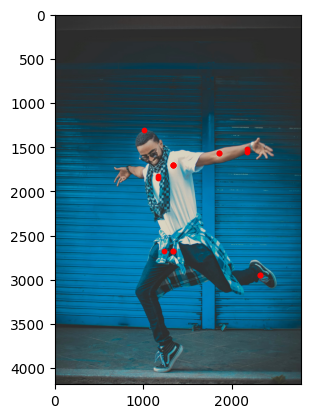

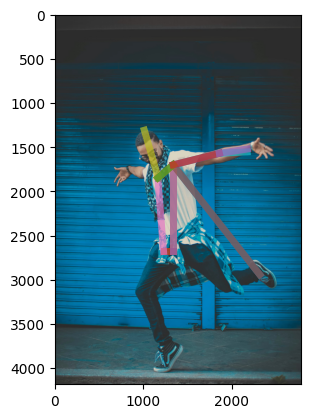

In [39]:
import os

test_image = os.path.join(PROJECT_PATH, 'test_image.jpg')

image, keypoints = predict(model, test_image)
draw_keypoints_on_image(image, keypoints)
draw_skeleton_on_image(image, keypoints)

지금까지 StackedHourglass Network  
simplebaseline  모델로 변경 (simplebaseline.py 파일과 이전에 살펴본 Simplebaseline 내용을 참고하여 모델을 완성)  
학습 진행후 비교 (Pose Estimation 결과 시각화 (정성적 비교) / 학습 진행 경과 (loss 감소 현황))  
최소 3에포크, 5에포크 이상 권장


프로젝트 제출 루브릭  
  
tfrecord를 활용한 데이터셋 구성과 전처리를 통해 프로젝트 베이스라인 구성을 확인하였다.  
- MPII 데이터셋을 기반으로 1epoch에 30분 이내에 학습가능한 베이스라인을 구축하였다.  
simplebaseline 모델을 정상적으로 구현하였다.  
- simplebaseline 모델을 구현하여 실습코드의 모델을 대체하여 정상적으로 학습이 진행되었다.  
Hourglass 모델과 simplebaseline 모델을 비교분석한 결과를 체계적으로 정리하였다.  
- 두 모델의 pose estimation 테스트결과 이미지 및 학습진행상황 등을 체계적으로 비교분석하였다.

C:\Users\user\AppData\Local\Temp\ipykernel_30008\4292177818.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(WEIGHTS_PATH, map_location=device)


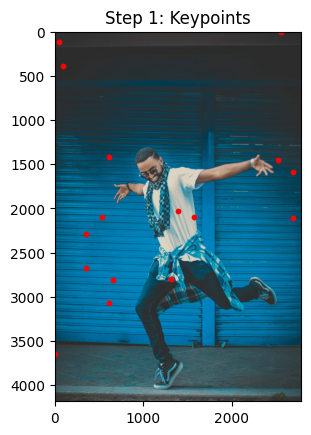

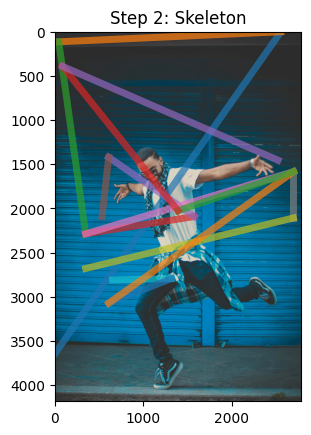

In [44]:
WEIGHTS_PATH = os.path.join(PROJECT_PATH, 'models', 'simplebaseline/model-epoch-10-loss-2.4603.pt')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = StackedHourglassNetwork(IMAGE_SHAPE, num_stack=4, num_residual=1, num_heatmap=num_heatmap)
model.to(device)
checkpoint = torch.load(WEIGHTS_PATH, map_location=device)
#model.load_state_dict(checkpoint)
model.eval() # 평가 모드로 변경

import os

test_image = os.path.join(PROJECT_PATH, 'test_image.jpg')

image, keypoints = predict(model, test_image)
draw_keypoints_on_image(image, keypoints)
draw_skeleton_on_image(image, keypoints)

# 회고

0. **학습을 진행하기 위해 별도 train_pose.py 파일을 만들어 학습을 진행하였고 만들어진 pt 파일을 다시 불러와 예측하는데 사용하였습니다.**

1. hourglass 학습 결과  
![hourglass](./hourglass.png)  
- 그래프를 보면 학습이 잘 진행된것같아 보인다. 하지만 Loss 값이 10에 가까운 것을 볼 수 있다. 또한 학습 횟수를 늘리면 더 안정적인 성능향상을 기대할 수 있을 것 같다.  

![hourglass](./hourglass_result1.png)|![hourglass](./hourglass_result2.png)
- 학습 과정에서 Loss 값이 너무 커서 학습이 잘 안된것은 아닐까 걱정을 했는데 생각보다 잘 예측된것같다.

2. simplebaseline  
![simplebaseline](./simplebaseline.png)  
- 그래프를 보면 역시 학습이 잘 진행된것같아 보인다. Loss 값도 높지 않아 예측 결과를 기대하였다.  

![simplebaseline](./simplebaseline_result1.png)|![simplebaseline](./simplebaseline_result2.png)  
- 학습 과정에서 기대했던것과 달리 결과가 잘 나오지 않았다. 결과를 봤을때 학습 과정에서 데이터 전처리 문제가 발생하지는 않았는지 의심이 들 정도이다. 이를 확인해 봐야 할 것 같다.

3. Hourglass vs SimpleBaseline 비교  
![hourglass](./hourglass.png) | ![simplebaseline](./simplebaseline.png)  

![hourglass](./hourglass_result2.png) | ![simplebaseline](./simplebaseline_result2.png)  
- 처음 학습 과정을 봤을때 전체적으로 학습은 잘 진행되었다고 판단이 되었고 Hourglass 모델이 Loss 값이 높게 나와 성능이 안좋을 것이라고 예상하였다. 
- 하지만 예측 결과의 시각화를 보면 Loss가 높게 나온 Hourglass 모델의 성능이 더 좋게 나온것을 확인할 수 있다.
- 먼저 simplebaseline의 성능을 확인해보기 위해 모델의 구조와 코드를 좀더 확인해봐야할 것같다.